<a href="https://colab.research.google.com/github/yustiks/retina_transfer_learning/blob/master/Webcam_pliers_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📸 Predict tools with webcam


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# I have no idea who is the author of the code
# in this cell that saves an image from a webcam
# inside google colab.
# It comes from a notebook called "📸 Take a photo with your webcam"

from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import io
from PIL import Image

VIDEO_HTML = """
<video autoplay
 width=%d height=%d style='cursor: pointer;'></video>
<script>

var video = document.querySelector('video')

navigator.mediaDevices.getUserMedia({ video: true })
  .then(stream=> video.srcObject = stream)
  
var data = new Promise(resolve=>{
  video.onclick = ()=>{
    var canvas = document.createElement('canvas')
    var [w,h] = [video.offsetWidth, video.offsetHeight]
    canvas.width = w
    canvas.height = h
    canvas.getContext('2d')
          .drawImage(video, 0, 0, w, h)
    video.srcObject.getVideoTracks()[0].stop()
    video.replaceWith(canvas)
    resolve(canvas.toDataURL('image/jpeg', %f))
  }
})
</script>
"""
def take_photo(filename='photo.jpg', quality=0.8, size=(800,600)):
  display(HTML(VIDEO_HTML % (size[0],size[1],quality)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  f = io.BytesIO(binary)
  return np.asarray(Image.open(f))
#   with open(filename, 'wb') as f:
#     f.write(binary)
#   return len(binary)

In [9]:
!git clone https://github.com/fizyr/keras-retinanet.git

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 5274 (delta 2), reused 1 (delta 0), pack-reused 5264
Receiving objects: 100% (5274/5274), 13.29 MiB | 6.88 MiB/s, done.
Resolving deltas: 100% (3521/3521), done.


In [3]:
%cd keras-retinanet/

/content/keras-retinanet


In [26]:
!git checkout 42068ef9e406602d92a1afe2ee7d470f7e9860df

HEAD is now at 42068ef Merge pull request #621 from borakrc/fix-anchor-boxes-not-shown


In [27]:
!pip install .

Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-0.4.1-cp36-cp36m-linux_x86_64.whl size=155987 sha256=36d129c1fe2d68585a0d242d6484ec7411e97f5772e542c91a9736cd6da51838
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
Successfully built keras-retinanet
  Found existing installation: keras-retinanet 0.5.1
    Uninstalling keras-retinanet-0.5.1:
      Successfully uninstalled keras-retinanet-0.5.1


In [4]:
!python setup.py build_ext --inplace

running build_ext
skipping 'keras_retinanet/utils/compute_overlap.c' Cython extension (up-to-date)
copying build/lib.linux-x86_64-3.6/keras_retinanet/utils/compute_overlap.cpython-36m-x86_64-linux-gnu.so -> keras_retinanet/utils


In [0]:

import os
import shutil
import zipfile
import urllib
import xml.etree.ElementTree as ET
import numpy as np
import csv
import pandas
from google.colab import drive
from google.colab import files

In [7]:
#!/usr/bin/env python
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%reload_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())


Using TensorFlow backend.


In [0]:

def get_session():
    """ Construct a modified tf session.
    """
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

In [9]:

%%time
keras.backend.tensorflow_backend.set_session(get_session())
path_to_model='/content/drive/My Drive/resnet50_csv_20_KTH.h5'
backbone='resnet50'
# load the model
print('Loading model, this may take a second...')
model = models.load_model(path_to_model, backbone_name=backbone, convert=True)

Loading model, this may take a second...












Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



CPU times: user 14 s, sys: 1.51 s, total: 15.5 s
Wall time: 22 s


In [0]:
from PIL import ImageFont, ImageDraw
labels_to_names = {1: 'зубило',2:'молоток',3:'плоскогубцы',4:'гаечный ключ'}
fontpath = "/content/drive/My Drive/wqy-zenhei.ttf"
font = ImageFont.truetype(fontpath, 14)

In [0]:
def draw_online(img):
  draw = img.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
  
  # preprocess image for network
  image = preprocess_image(img)
  image, scale = resize_image(img)

  # process image
  boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
  #boxes, scores = prediction_model.predict_on_batch(np.expand_dims(image, axis=0))

  # correct for image scale
  boxes /= scale

  # visualize detections
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
  #for box, score  in zip(boxes[0], scores[0]):
      # scores are sorted so we can break
      #print (score[0],len(score))
      if score < 0.81 or label!=3:
          break

      #label=0   
      #color = label_color(label)
      color = label_color(label)

      b = box.astype(int)
      draw_box(draw, b, color=color)
      caption = "{} {:.3f}".format(labels_to_names[label], score)
      #draw_caption(draw, b, caption)
      img_pil = Image.fromarray(draw)
      draw_ = ImageDraw.Draw(img_pil)
      draw_.text((b[0], b[1] - 15),  caption, font = font)
      draw = np.array(img_pil)
      draw1 = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
      #cv2.imwrite('/content/drive/My Drive/retina/' + str(i) + '.jpg', draw1)

  plt.figure(figsize=(15, 15))
  plt.axis('off')
  plt.imshow(draw1)
  plt.show()

In [0]:
def draw_online(img):
  draw = img.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
  
  # preprocess image for network
  image = preprocess_image(img)
  image, scale = resize_image(img)

  # process image
  boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
  #boxes, scores = prediction_model.predict_on_batch(np.expand_dims(image, axis=0))

  # correct for image scale
  boxes /= scale

  # visualize detections
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
  #for box, score  in zip(boxes[0], scores[0]):
      # scores are sorted so we can break
      #print (score[0],len(score))
      if score < 0.81 or label!=3:
          break

      #label=0   
      #color = label_color(label)
      color = label_color(label)

      b = box.astype(int)
      draw_box(draw, b, color=color)
      caption = "{} {:.3f}".format(labels_to_names[label], score)
      #draw_caption(draw, b, caption)
      img_pil = Image.fromarray(draw)
      draw_ = ImageDraw.Draw(img_pil)
      draw_.text((b[0], b[1] - 15),  caption, font = font)
      draw = np.array(img_pil)
      
      #cv2.imwrite('/content/drive/My Drive/retina/' + str(i) + '.jpg', draw1)
  draw1 = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
  plt.figure(figsize=(15, 15))
  plt.axis('off')
  plt.imshow(draw1)
  plt.show()

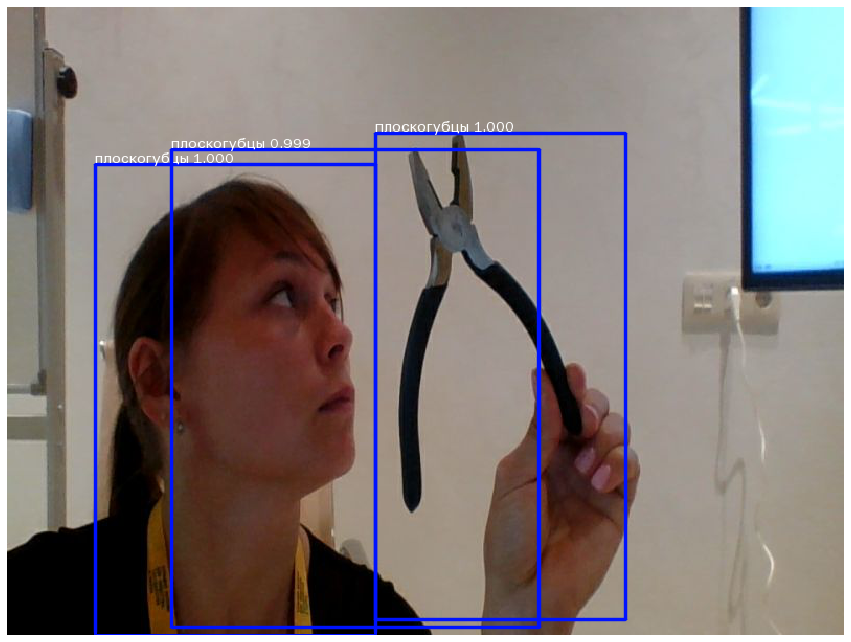

In [46]:
img = take_photo()
draw_online(img)
